In [3]:
pwd

'd:\\online class\\DeepLearning\\gradCAM'

In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import torch
import torch.nn.functional as F
from torchvision import models, transforms


In [5]:
# Load and preprocess the image
img = Image.open('C:\\Users\\uniqu\\Documents\\test\\squirrel_monkey 1.jpg')
img
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
input_tensor.shape


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\uniqu\\Documents\\test\\squirrel_monkey 1.jpg'

In [32]:
# Define the GradCAM class
class GradCAM:
    def __init__(self, model, target_layer) -> None:
        self.model = model
        self.target_layer = target_layer
        self.activation_maps = None
        self.gradient_maps = None
        self.hook()

    def hook(self):
        def forward_hook(module, in_activation_maps, out_activation_maps):
            self.activation_maps = out_activation_maps

        def backward_hook(module, grad_in, grad_out):
            self.gradient_maps = grad_out[0]

        target_layer_module = dict(self.model.named_modules())[self.target_layer]
        target_layer_module.register_forward_hook(forward_hook)
        target_layer_module.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor):
        output = self.model(input_tensor)
        class_idx = torch.argmax(output, dim=1)

        self.model.zero_grad()
        target_class = output[:, class_idx]
        target_class.backward()

        # Compute Global Average Pooling
        weights = torch.mean(self.gradient_maps, dim=(2, 3))

        cam = torch.zeros(self.activation_maps.shape[2:], dtype=torch.float32)

        for i, w in enumerate(weights[0]):
            cam += w * self.activation_maps[0, i, :, :]

        cam = F.relu(cam)
        return (cam - cam.min()) / (cam.max() - cam.min())


In [33]:
# Load the VGG16 pre-trained model
vgg_model = models.vgg16(pretrained=True)
vgg_model.eval()


c:\Users\uniqu\Documents\test\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\uniqu\Documents\test\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

c:\Users\uniqu\Documents\test\venv\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


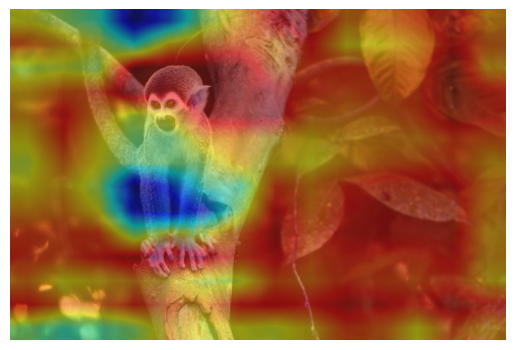

In [34]:
# Generate Grad-CAM for the last convolutional layer (index 29)
grad_cam_last = GradCAM(vgg_model, 'features.29')  # Target the last layer
cam_last = grad_cam_last.generate_cam(input_tensor)

# Prepare the original image for overlay
original_img = np.array(img)
if original_img.ndim == 2:
    original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)
else:
    original_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
original_img = np.float32(original_img) / 255

# Create heatmap and overlay for the last layer
cam_last = cam_last.detach().numpy()
cam_last = cv2.resize(cam_last, (original_img.shape[1], original_img.shape[0]))
heatmap_last = cv2.applyColorMap(np.uint8(cam_last * 255), cv2.COLORMAP_JET)
overlay_last = heatmap_last / 255 + original_img
overlay_last = overlay_last / np.max(overlay_last)
plt.imshow(overlay_last)
plt.axis('off')
plt.show()


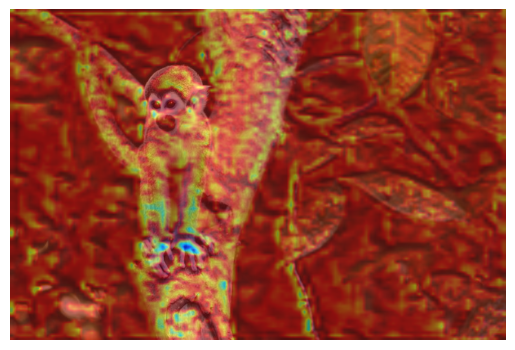

In [35]:
# Generate Grad-CAM for the first convolutional layer (index 0)
grad_cam_first = GradCAM(vgg_model, 'features.5')  # Target the first layer
cam_first = grad_cam_first.generate_cam(input_tensor)

# Create heatmap and overlay for the first layer
cam_first = cam_first.detach().numpy()
cam_first = cv2.resize(cam_first, (original_img.shape[1], original_img.shape[0]))
heatmap_first = cv2.applyColorMap(np.uint8(cam_first * 255), cv2.COLORMAP_JET)
overlay_first = heatmap_first / 255 + original_img
overlay_first = overlay_first / np.max(overlay_first)
plt.imshow(overlay_first)
plt.axis('off')
plt.show()
